# Predicting Terrorist Attacks
## Time Series Prediction

**Author:** Thomas Skowronek

**Date:** April 15, 2018

### Notebook Configuration

In [130]:
import time
import collections

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [131]:
# Display up to 150 rows and columns
pd.set_option('display.max_rows', 220)
pd.set_option('display.max_columns', 150)

# Set the figure size for plots
mpl.rcParams['figure.figsize'] = (14.6, 9.0)

# Set the Seaborn default style for plots
sns.set()

# Set the color palette
sns.set_palette(sns.color_palette("muted"))

### Load the Datasets
Load the dataset created by the EDA notebook.

In [132]:
# Load the preprocessed GTD dataset
gtd_df = pd.read_csv('../data/gtd_eda_95t016.csv', low_memory=False, index_col = 0,
                      na_values=[''])

### Inspect the Structure
The cleansed data frame contains 48 attributes, one of which is used for the data frame index, and 110,844 observations.

In [133]:
# Display a summary of the data frame
gtd_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110844 entries, 199501000001 to 201701270001
Data columns (total 48 columns):
iyear               110844 non-null int64
imonth              110844 non-null int64
iday                110844 non-null int64
country_txt         110844 non-null object
region_txt          110844 non-null object
provstate           110844 non-null object
city                110844 non-null object
latitude            110844 non-null float64
longitude           110844 non-null float64
specificity         110844 non-null float64
summary             110844 non-null object
attacktype1_txt     110844 non-null object
targtype1_txt       110844 non-null object
targsubtype1_txt    110844 non-null object
corp1               110844 non-null object
target1             110844 non-null object
natlty1_txt         110844 non-null object
gname               110844 non-null object
nperpcap            110844 non-null float64
weaptype1_txt       110844 non-null object
weapsubtype

### Convert Attributes to Correct Data Type
Convert a subset of the data frame attributes to categorical, datatime and string to align with the GTD code book as executed previously in the EDA notebook.

In [134]:
# List of attributes that are categorical
cat_attrs = ['extended_txt', 'country_txt', 'region_txt', 'specificity', 'vicinity_txt',
             'crit1_txt', 'crit2_txt', 'crit3_txt', 'doubtterr_txt', 'multiple_txt',
             'success_txt', 'suicide_txt', 'attacktype1_txt', 'targtype1_txt', 
             'targsubtype1_txt', 'natlty1_txt', 'guncertain1_txt', 'individual_txt', 
             'claimed_txt', 'weaptype1_txt', 'weapsubtype1_txt', 'property_txt', 
             'ishostkid_txt', 'INT_LOG_txt', 'INT_IDEO_txt','INT_MISC_txt', 'INT_ANY_txt']

for cat in cat_attrs:
    gtd_df[cat] = gtd_df[cat].astype('category')

# Data time feature added during EDA
gtd_df['incident_date'] = pd.to_datetime(gtd_df['incident_date'])

# Necessary for single data type
gtd_df['gname'] = gtd_df['gname'].astype('str')
    
gtd_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110844 entries, 199501000001 to 201701270001
Data columns (total 48 columns):
iyear               110844 non-null int64
imonth              110844 non-null int64
iday                110844 non-null int64
country_txt         110844 non-null category
region_txt          110844 non-null category
provstate           110844 non-null object
city                110844 non-null object
latitude            110844 non-null float64
longitude           110844 non-null float64
specificity         110844 non-null category
summary             110844 non-null object
attacktype1_txt     110844 non-null category
targtype1_txt       110844 non-null category
targsubtype1_txt    110844 non-null category
corp1               110844 non-null object
target1             110844 non-null object
natlty1_txt         110844 non-null category
gname               110844 non-null object
nperpcap            110844 non-null float64
weaptype1_txt       110844 non-null categ

### Drop Text Attributes
Remove the text attributes, which will not be used in the models.

In [135]:
gtd_df = gtd_df.drop(['provstate', 'city', 'summary', 'corp1', 'target1',
                                  'scite1', 'dbsource'], axis=1)

gtd_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110844 entries, 199501000001 to 201701270001
Data columns (total 41 columns):
iyear               110844 non-null int64
imonth              110844 non-null int64
iday                110844 non-null int64
country_txt         110844 non-null category
region_txt          110844 non-null category
latitude            110844 non-null float64
longitude           110844 non-null float64
specificity         110844 non-null category
attacktype1_txt     110844 non-null category
targtype1_txt       110844 non-null category
targsubtype1_txt    110844 non-null category
natlty1_txt         110844 non-null category
gname               110844 non-null object
nperpcap            110844 non-null float64
weaptype1_txt       110844 non-null category
weapsubtype1_txt    110844 non-null category
nkill               110844 non-null float64
nkillus             110844 non-null float64
nkillter            110844 non-null float64
nwound              110844 non-nul

### Standardize the Numeric Attributes
Adjust for differences in the range of the numeric attributes.

In [136]:
scaler = preprocessing.StandardScaler()

# List of numeric attributes
scale_attrs = ['nperpcap', 'nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte']

# Normalize the attributes in place
gtd_df[scale_attrs] = scaler.fit_transform(gtd_df[scale_attrs])

# View the transformation
gtd_df[scale_attrs].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nperpcap,110844.0,1.960960e-15,1.000005,-0.054077,-0.054077,-0.054077,-0.054077,198.817891
nkill,110844.0,-5.648572e-18,1.000005,-0.210294,-0.210294,-0.125198,-0.040102,127.433877
nkillus,110844.0,6.443646e-15,1.000005,-0.006761,-0.006761,-0.006761,-0.006761,235.898995
nkillter,110844.0,3.473713e-14,1.000005,-0.107231,-0.107231,-0.107231,-0.107231,124.009492
nwound,110844.0,1.105829e-14,1.000005,-0.090709,-0.090709,-0.090709,-0.016278,182.661051
nwoundus,110844.0,-1.255198e-15,1.000005,-0.011179,-0.011179,-0.011179,-0.011179,303.576370
nwoundte,110844.0,4.018359e-14,1.000005,-0.063042,-0.063042,-0.063042,-0.063042,144.255041


### Iraq
Subset the data to the last 10 year of events in Iraq.

In [137]:
iraq_df = gtd_df[gtd_df['country_txt'] == "Iraq"].query('2006<iyear<=2016')

iraq_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20024 entries, 200701040002 to 201612310031
Data columns (total 41 columns):
iyear               20024 non-null int64
imonth              20024 non-null int64
iday                20024 non-null int64
country_txt         20024 non-null category
region_txt          20024 non-null category
latitude            20024 non-null float64
longitude           20024 non-null float64
specificity         20024 non-null category
attacktype1_txt     20024 non-null category
targtype1_txt       20024 non-null category
targsubtype1_txt    20024 non-null category
natlty1_txt         20024 non-null category
gname               20024 non-null object
nperpcap            20024 non-null float64
weaptype1_txt       20024 non-null category
weapsubtype1_txt    20024 non-null category
nkill               20024 non-null float64
nkillus             20024 non-null float64
nkillter            20024 non-null float64
nwound              20024 non-null float64
nwoundus   

### Attacks per Day
Calculate the number of attacks per day.

In [138]:
# Group by incident_date
iraq_counts = iraq_df.groupby(['incident_date'], as_index = False).count()

# Select incident_date and a column for the counts
iraq_counts = iraq_counts[['incident_date', 'iyear']]
iraq_counts.columns = ['incident_date','daily_attacks']
iraq_counts.head()

,incident_date,daily_attacks
0,2007-01-04,1
1,2007-01-05,1
2,2007-01-06,1
3,2007-01-08,3
4,2007-01-10,5


### Reindex and Fill
Reindex the dataframe to include all days for the 10 year period and fill added days with zero.

In [139]:
idx = pd.date_range('2007-01-01', '2016-12-31')

iraq_ts = iraq_counts.set_index('incident_date')

iraq_ts = iraq_ts.reindex(idx, fill_value=0)
iraq_ts.head()

,daily_attacks
2007-01-01,0
2007-01-02,0
2007-01-03,0
2007-01-04,1
2007-01-05,1


### Summary Statistics
Display summary statistics on the time series dataframe.

In [140]:
iraq_ts.describe()

,daily_attacks
count,3653.000000
mean,5.481522
std,5.790473
min,0.000000
25%,2.000000
50%,4.000000
75%,8.000000
max,108.000000


### Daily Plot - Total Attacks

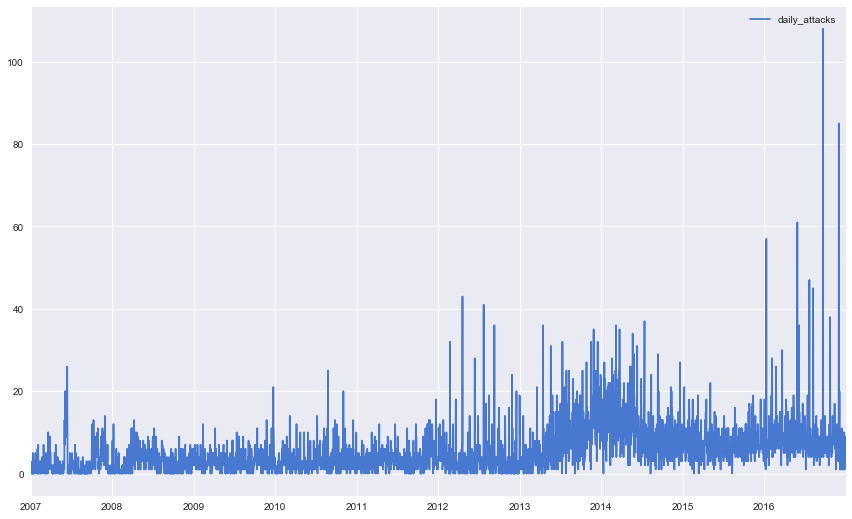

In [141]:
iraq_ts.plot()
plt.show();

### Weekly Plot - Average Attacks

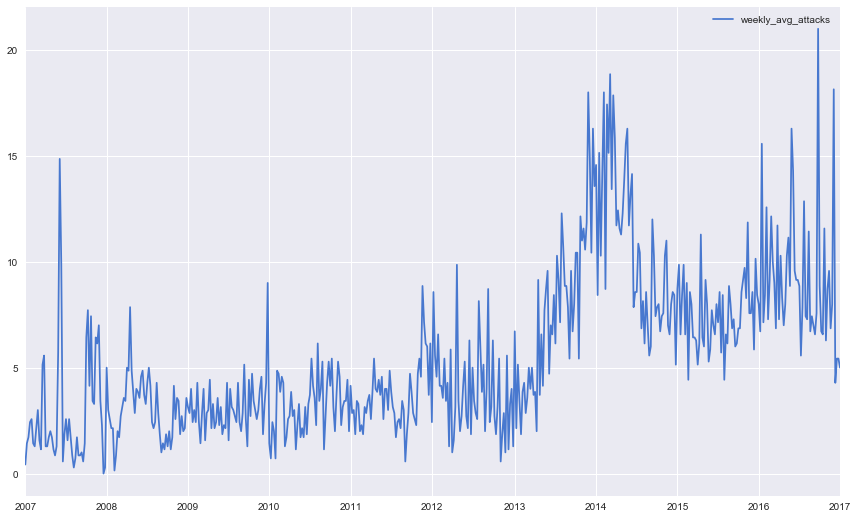

In [142]:
weekly_summary = pd.DataFrame()
weekly_summary['weekly_avg_attacks'] = iraq_ts.daily_attacks.resample('W').mean()

weekly_summary.plot()
plt.show();

### Monthly Plot - Average Attacks

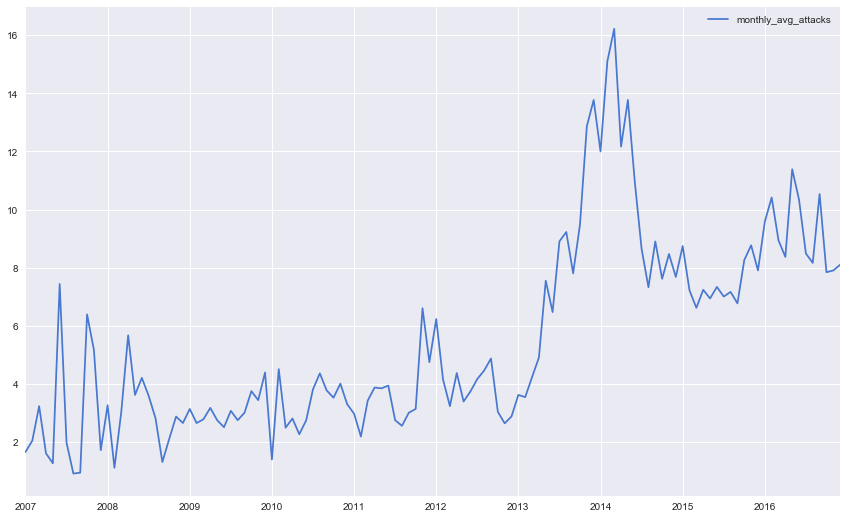

In [143]:
monthly_summary = pd.DataFrame()
monthly_summary['monthly_avg_attacks'] = iraq_ts.daily_attacks.resample('M').mean()

monthly_summary.plot()
plt.show();

In [144]:
# Use a 20 day span for averaging
iraq_ewm = iraq_ts.ewm(span=20, adjust=False).mean()

iraq_ewm.head()

,daily_attacks
2007-01-01,0.000000
2007-01-02,0.000000
2007-01-03,0.000000
2007-01-04,0.095238
2007-01-05,0.181406


### Exponential Weighted Moving Average
Daily attacks in Iraq, 2007 to 2016.

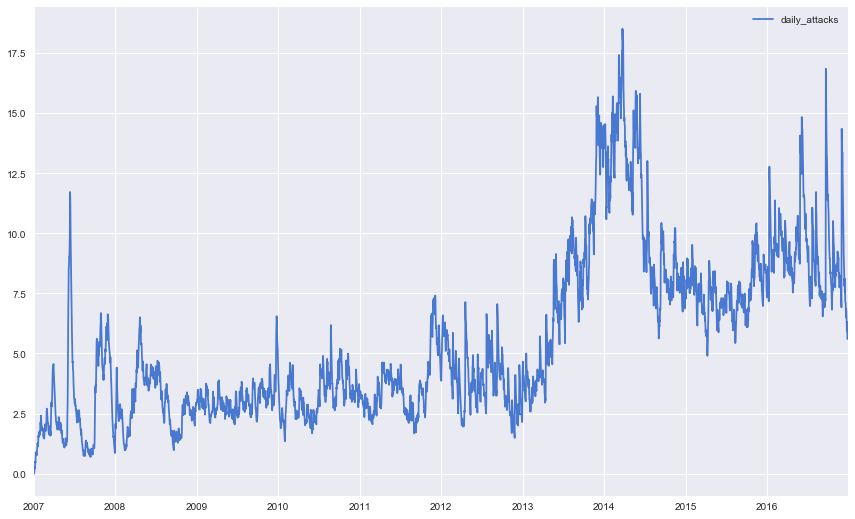

In [145]:
iraq_ewm.plot()
plt.show();

### Facebook Prophet
Create a modified dataset to comply with the Facebook Prophet requirements.

In [146]:
import fbprophet

iraq_fb = iraq_ewm.copy()
iraq_fb['index1'] = iraq_fb.index
iraq_fb.columns = ['y', 'ds']

iraq_fb.head()

,y,ds
2007-01-01,0.000000,2007-01-01
2007-01-02,0.000000,2007-01-02
2007-01-03,0.000000,2007-01-03
2007-01-04,0.095238,2007-01-04
2007-01-05,0.181406,2007-01-05


### Time Series Model
Create the time serie model for attacks in Iraq.

In [147]:
# Make the prophet model and fit on the data
prophet1 = fbprophet.Prophet(changepoint_prior_scale=0.15)
prophet1.fit(iraq_fb)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Predict 14 days Out
Predict 14 days after last the data point of 2016-12-31.

In [148]:
# Specify 14 days out to predict
future_data = prophet1.make_future_dataframe(periods=14, freq = 'D')

# Predict the values
forecast_data = prophet1.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3662,2017-01-10,9.723988,8.197334,11.343598
3663,2017-01-11,9.804098,8.145617,11.401444
3664,2017-01-12,9.841215,8.278154,11.455965
3665,2017-01-13,9.704554,8.106271,11.386523
3666,2017-01-14,9.675122,8.025022,11.184294


### Plot the Predictions

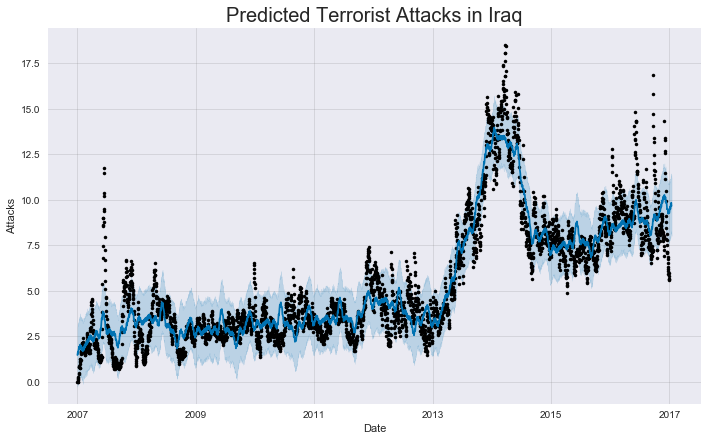

In [149]:
prophet1.plot(forecast_data, xlabel = 'Date', ylabel = 'Attacks')
plt.title('Predicted Terrorist Attacks in Iraq', fontsize=20);
plt.show();

### Zoom in to the Last 2 Months Plus Predictions

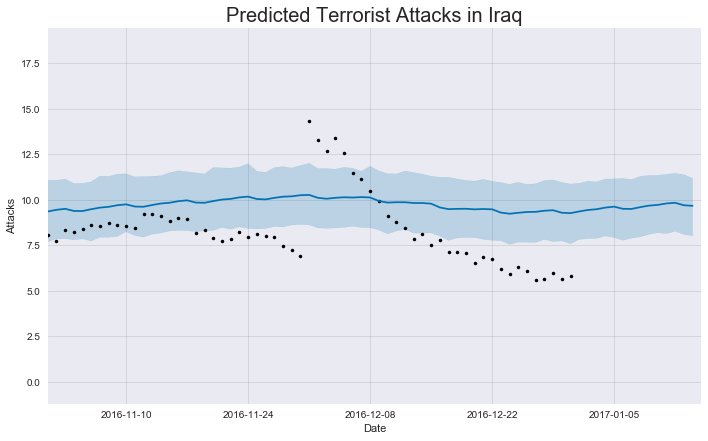

In [150]:
prophet1.plot(forecast_data, xlabel = 'Date', ylabel = 'Attacks')
plt.title('Predicted Terrorist Attacks in Iraq', fontsize=20);
plt.xlim(pd.Timestamp('2016-11-01'), pd.Timestamp('2017-01-15'))
plt.show();

### References

Keen, B. (2017). Feature scaling with scikit-learn Retrieved from http://benalexkeen.com/feature-scaling-with-scikit-learn/